In [302]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import string
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect('./zippedData/im.db')
TheNumbers = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

In [303]:
punct = '$,'   # `|` is not present here
money_to_num = str.maketrans(dict.fromkeys(punct, ''))

#stripping dollar-sign and commas from relevant objects
TheNumbers['worldwide_gross'] = '|'.join(TheNumbers['worldwide_gross'].tolist()).translate(money_to_num).split('|')
TheNumbers['domestic_gross'] = '|'.join(TheNumbers['domestic_gross'].tolist()).translate(money_to_num).split('|')
TheNumbers['production_budget'] = '|'.join(TheNumbers['production_budget'].tolist()).translate(money_to_num).split('|')
#converting number strings to int64 types
TheNumbers['worldwide_gross'] = TheNumbers['worldwide_gross'].astype(np.int64)
TheNumbers['domestic_gross'] = TheNumbers['domestic_gross'].astype(np.int64)
TheNumbers['production_budget'] = TheNumbers['production_budget'].astype(np.int64)
#convert release date to a datetime
TheNumbers['release_date'] = pd.to_datetime(TheNumbers['release_date'])


#created variables for domestic profit, worldwide profit, domestic & worldwide profit margins (profit/gross)
TheNumbers['domestic_profit'] = TheNumbers['domestic_gross'] - TheNumbers['production_budget']
TheNumbers['worldwide_profit'] = TheNumbers['worldwide_gross'] - TheNumbers['production_budget']
TheNumbers['domestic_margin'] = TheNumbers['domestic_profit'] / TheNumbers['domestic_gross']
TheNumbers['worldwide_margin'] = TheNumbers['worldwide_profit'] / TheNumbers['worldwide_gross']

### New Metrics created for TheNumbers
- domestic_profit
- worldwide_profit
- domestic_margin
- worldwide_margin

In [304]:
#created variables for domestic profit, worldwide profit, domestic & worldwide profit margins (profit/gross)
TheNumbers['domestic_profit'] = TheNumbers['domestic_gross'] - TheNumbers['production_budget']
TheNumbers['worldwide_profit'] = TheNumbers['worldwide_gross'] - TheNumbers['production_budget']
TheNumbers['domestic_margin'] = TheNumbers['domestic_profit'] / TheNumbers['domestic_gross']
TheNumbers['worldwide_margin'] = TheNumbers['worldwide_profit'] / TheNumbers['worldwide_gross']

In [347]:
TheNumbers.tail()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,domestic_margin,worldwide_margin
5777,78,2018-12-31,Red 11,7000,0,0,-7000,-7000,-inf,-inf
5778,79,1999-04-02,Following,6000,48482,240495,42482,234495,0.876243,0.975051
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,-3662,-3662,-2.736921,-2.736921
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,-1400,-1400,-inf,-inf
5781,82,2005-08-05,My Date With Drew,1100,181041,181041,179941,179941,0.993924,0.993924


In [341]:
TheNumbers.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
domestic_profit      0
worldwide_profit     0
domestic_margin      0
worldwide_margin     0
dtype: int64

### Production budget vs genre
- Create a dataframe that takes all of the production_budget info in from TheNumbers, and then is able to assign genres from IMDB. Connect the movie names to their genres.
- Group the genres and chart vs total budget, profit, margins

In [306]:
query = '''
SELECT
    primary_title,
    genres
FROM
    movie_basics
    '''
movie_genre = pd.read_sql(query, conn)
movie_genre.head()

,primary_title,genres
0,Sunghursh,"Action,Crime,Drama"
1,One Day Before the Rainy Season,"Biography,Drama"
2,The Other Side of the Wind,Drama
3,Sabse Bada Sukh,"Comedy,Drama"
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy"


#### Clean genres into a list. Set movie name as index.

In [307]:
movie_genre['genres_list'] = movie_genre['genres'].str.split()


movie_actors = movie_actors[movie_actors['job'] == 'actor']

ranked_movies join movie_actors
-->
movie title, movie id, qualifier, [actors]


In [308]:
# There are some duplicates that need to be dropped
movie_genre.drop_duplicates(subset=['primary_title'], inplace=True)

In [309]:
# Set movie name as index
movie_genre.set_index('primary_title', inplace=True)
movie_genre.head()

,genres,genres_list
primary_title,,
Sunghursh,"Action,Crime,Drama","[Action,Crime,Drama]"
One Day Before the Rainy Season,"Biography,Drama","[Biography,Drama]"
The Other Side of the Wind,Drama,[Drama]
Sabse Bada Sukh,"Comedy,Drama","[Comedy,Drama]"
The Wandering Soap Opera,"Comedy,Drama,Fantasy","[Comedy,Drama,Fantasy]"


In [340]:
movie_genre.isna()

,genres,genres_list
primary_title,,
Sunghursh,False,False
One Day Before the Rainy Season,False,False
The Other Side of the Wind,False,False
Sabse Bada Sukh,False,False
The Wandering Soap Opera,False,False
...,...,...
The Secret of China,False,False
Kuambil Lagi Hatiku,False,False
Rodolpho Teóphilo - O Legado de um Pioneiro,False,False


In [311]:
# Remove movies without genre
movie_genre.dropna(subset=['genres_list'], inplace=True)

#### Combine this movie_genre with TheNumbers

In [312]:
money_genre = TheNumbers.join(movie_genre, on='movie', how = 'inner')

#### Get all unique genres

In [313]:
genres = money_genre['genres'].unique().tolist()

In [314]:
unique_genres = []
for x in genres:
    templist = x.split(",")
    for y in templist:
        unique_genres.append(y)
unique_genres = list(set(unique_genres))

In [337]:
unique_genres

['Family',
 'Crime',
 'War',
 'Sci-Fi',
 'Comedy',
 'Fantasy',
 'Horror',
 'Musical',
 'Action',
 'Sport',
 'Biography',
 'Animation',
 'Romance',
 'News',
 'Documentary',
 'Western',
 'Adventure',
 'Mystery',
 'History',
 'Drama',
 'Music',
 'Thriller']

In [316]:
# genres_df is dict where key = genre, value = df of movies with that genre
genres_df = {x: money_genre[money_genre.genres.str.contains(x)] for x in genres_df}

## Chart production costs vs revenue for each genre


In [365]:
type(genres_df.keys())

dict_keys

AttributeError: 'PathCollection' object has no attribute 'legend'

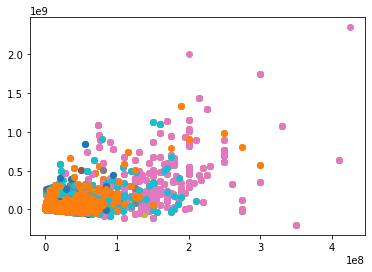

In [370]:
fig = plt.figure()
ax = plt.subplot(111)


for genre,frame in genres_df.items():
    ax = plt.scatter(frame['production_budget'], frame['worldwide_profit'], label='')

ax.legend()
fig.set_xlabel('production_budget')
fig.set_ylabel('worldwide_profit')

In [352]:

# fig, axs = plt.subplots(11,1)

# x=0
# y=0

# for genre,frame in genres_df.items():
#     axs[x,y].plot(frame['production_budget'], frame['worldwide_profit'])
#     axs[x,y].set_title(genre)

#     x =+1


    

In [ ]:
# Revenue per genre